In [11]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def load_and_merge_data(feature_file, age_file):
    """
    Load features and age CSVs, merge on Patient_ID, and return a DataFrame.
    """
    try:
        features_df = pd.read_csv(feature_file)
        if 'ID' not in features_df.columns:
            raise ValueError("ID column not found in extracted_features.csv")
        
        age_df = pd.read_csv(age_file)
        if 'ID' not in age_df.columns or 'Age' not in age_df.columns:
            raise ValueError("ID or Age column not found in oasis_cross-sectional-5708aa0a98d82080.csv")
        
        df = pd.merge(features_df, age_df[['ID', 'Age']], on='ID', how='inner')
        
        if df.empty:
            raise ValueError("No matching IDs found between feature and age CSVs")
        
        print(f"Merged data for {len(df)} patients.")
        return df
    except Exception as e:
        print(f"Error loading or merging data: {e}")
        return None


In [3]:
def perform_xgb_regression(df, importance_threshold=0.05):
    """
    Perform XGBoost regression and calculate brain age gap.
    Returns model, predictions, feature importances, and brain age gap.
    """
    X = df.drop(columns=['ID', 'Age'])
    y = df['Age']
    feature_names = X.columns
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define XGBoost model with eval_metric
    xgb = XGBRegressor(random_state=42, objective='reg:squarederror', eval_metric='mae')
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_lambda': [0, 0.1, 1.0]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    model = grid_search.best_estimator_
    print(f"Best XGBoost parameters: {grid_search.best_params_}")
    
    # Train final model (no early stopping due to version limitations)
    model.fit(X_train, y_train)
    
    # Cross-validated performance
    mae_scores = -cross_val_score(model, X_scaled, y, cv=10, scoring='neg_mean_absolute_error')
    print(f"Cross-validated MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f} years")
    
    # Predict brain age
    y_pred = model.predict(X_test)
    
    # Calculate brain age gap
    brain_age_gap = y_pred - y_test
    
    # Evaluate on test set
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test Set Mean Absolute Error: {mae:.2f} years")
    print(f"Test Set R² Score: {r2:.2f}")
    
    # Feature importance
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance_df)
    
    # Suggest features to keep
    important_features = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()
    print(f"\nSuggested features to keep (importance >= {importance_threshold}):")
    print(important_features)
    
    return model, X_test, y_test, y_pred, brain_age_gap, df.loc[y_test.index, 'ID'], feature_importance_df

In [4]:
def visualize_results(y_test, y_pred, brain_age_gap, feature_importance_df):
    """
    Visualize predicted vs actual age, brain age gap distribution, and feature importance.
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Predicted vs Actual Brain Age (XGBoost)')
    
    plt.subplot(1, 3, 2)
    plt.hist(brain_age_gap, bins=20, edgecolor='black')
    plt.xlabel('Brain Age Gap (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.title('Brain Age Gap Distribution (XGBoost)')
    
    plt.subplot(1, 3, 3)
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    
    plt.tight_layout()
    plt.show()

Enter the parent directory path (containing extract folder and CSVs): 
Loading and merging data...
Merged data for 31 patients.
Data preview:
              ID  image_size_x  image_size_y  image_size_z  pixel_size_x  \
0  OAS1_0001_MR1           176           208           176           1.0   
1  OAS1_0002_MR1           176           208           176           1.0   
2  OAS1_0003_MR1           176           208           176           1.0   
3  OAS1_0004_MR1           176           208           176           1.0   
4  OAS1_0005_MR1           176           208           176           1.0   

   pixel_size_y  pixel_size_z  tissue_0_mean  tissue_0_stddev  tissue_1_mean  \
0           1.0           1.0        384.521          162.773        851.126   
1           1.0           1.0        423.352          155.224        827.705   
2           1.0           1.0        387.006          158.527        896.728   
3           1.0           1.0        403.657          149.747        801.315   
4

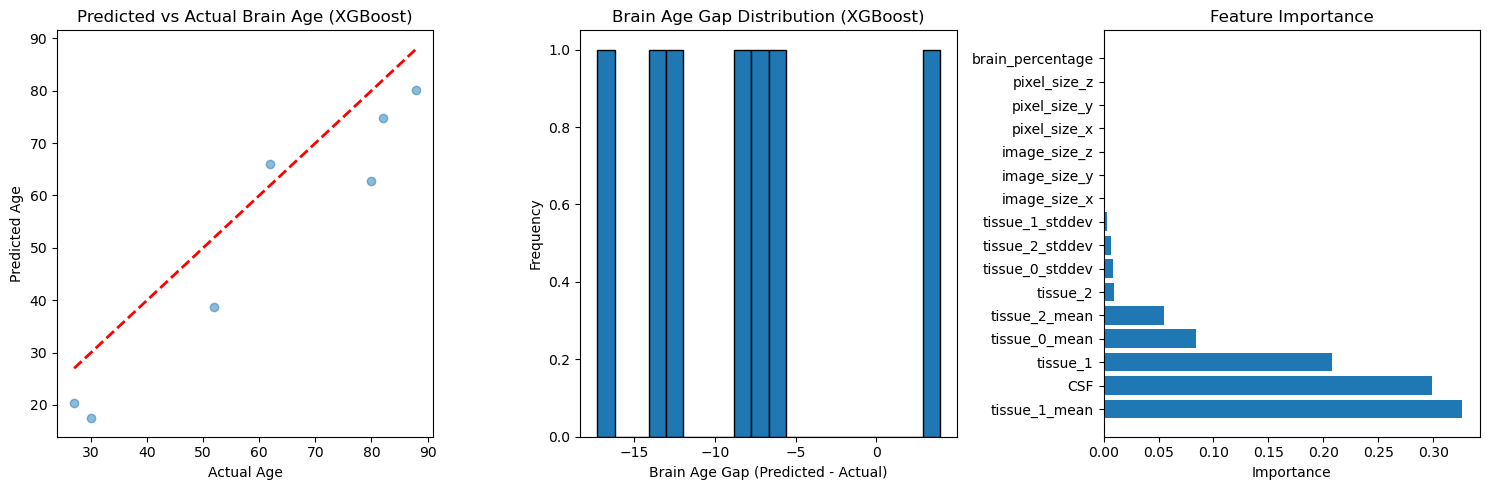


Results saved to RE_xgb_results.csv


In [8]:
if __name__ == "__main__":
    parent_dir = input("Enter the parent directory path (containing extract folder and CSVs): ")
    
    feature_file = os.path.join(parent_dir, 'extracted_features.csv')
    age_file = os.path.join(parent_dir, 'oasis_cross-sectional-5708aa0a98d82080.csv')
    
    print("Loading and merging data...")
    df = load_and_merge_data(feature_file, age_file)
    
    if df is None or df.empty:
        print("Failed to load data. Please check file paths and formats.")
    else:
        print("Data preview:")
        print(df.head())
        
        print("\nTraining XGBoost model...")
        model, X_test, y_test, y_pred, brain_age_gap, test_patient_ids, feature_importance_df = perform_xgb_regression(df)
        
        print("\nVisualizing results...")
        visualize_results(y_test, y_pred, brain_age_gap, feature_importance_df)
        
        results = pd.DataFrame({
            'ID': test_patient_ids,
            'Actual_Age': y_test,
            'Predicted_Age': y_pred,
            'Brain_Age_Gap': brain_age_gap
        })
        results.to_csv(os.path.join(parent_dir, 'RE_xgb_results.csv'), index=False)
        print(f"\nResults saved to {os.path.join(parent_dir, 'RE_xgb_results.csv')}")

In [6]:
!pip show xgboost

Name: xgboost
Version: 3.0.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\wjw_4\anaconda3\Lib\site-packages
Requires: numpy, scipy
Required-by: 


# Refine